# Fetch and plot data from multiple runs in the VIEWS API - Yemen example

Fetch a series of runs and plots in a line chart with actuals as bars. 

*No certificates/special access tokens are required.*

In [1]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from views_mapper2.label_writer import *
import os
home = os.path.expanduser("~")

## Select forecasts datasets

In [2]:
#datasets = ['2023_04','2023_05']
datasets = ['2023_04','2023_05','2023_06','2023_07','2023_08','2023_09','2023_10','2023_11','2023_12','2024_01','2024_02','2024_03','2024_04','2024_05','2024_06','2024_07','2024_08','2024_09','2024_09','2024_10']
country_name = 'Yemen'

## Fetch data
No need to edit this section. 

### Fetch identifiers (month_ids) from storage

In [3]:
from viewser import Queryset, Column

# Identifiers

month_ids = (Queryset("month_ids", "country_month")

.with_column(Column('month', from_loa = "month", from_column = 'month'))
.with_column(Column('year', from_loa = "country_year", from_column = 'year_id'))
)
      
month_ids = month_ids.publish().fetch()

print(f"A dataset with {len(month_ids.columns)} columns, with "
      f"data between t {min(month_ids.index.get_level_values(0))} "
      f"and {max(month_ids.index.get_level_values(0))}. "
      f"({len(np.unique(month_ids.index.get_level_values(1)))} units)"
     )

Queryset month_ids read successfully 
A dataset with 2 columns, with data between t 1 and 852. (213 units)


In [4]:
# Create a 'Date' column by combining 'year' and 'month'
month_ids['Date'] = month_ids['year'].astype(str) + '-' + month_ids['month'].astype(str)

month_ids

month  year     Date
month_id country_id                      
1        1               1  1980   1980-1
         2               1  1980   1980-1
         3               1  1980   1980-1
         4               1  1980   1980-1
         5               1  1980   1980-1
...                    ...   ...      ...
852      242            12  2050  2050-12
         243            12  2050  2050-12
         244            12  2050  2050-12
         245            12  2050  2050-12
         246            12  2050  2050-12

[158230 rows x 3 columns]

### Forecasts

In [5]:
PAGE_SIZE = 1000

for dataset in datasets:
    # Construct the API URL
    VIEWS_URL = f'https://api.viewsforecasting.org/fatalities002_{dataset}_t01/cm/sb/main_mean?iso=YEM&page_size={PAGE_SIZE}'
    master_list = []
    
    # Initial API request
    r = requests.get(VIEWS_URL)
    page_data = r.json()
    
    # Append the data from the first page
    master_list += page_data['data']
    
    # Handle pagination
    while page_data.get('next_page'):
        r = requests.get(page_data['next_page'])
        page_data = r.json()
        master_list += page_data['data']
    
    # Convert the collected data to a DataFrame
    df_raw = pd.DataFrame(master_list)
    
    # Create a 'Date' column by combining 'year' and 'month'
    df_raw['Date'] = df_raw['year'].astype(str) + '-' + df_raw['month'].astype(str)

    # Ensure 'month_id' and other date-related columns are numeric for filtering
    df_raw['month_id'] = pd.to_numeric(df_raw['month_id'], errors='coerce')  # Handle invalid values gracefully

    df_forecasts = df_raw.sort_values('month_id')  # Ensure ascending order

    # Save the filtered DataFrame to a variable dynamically
    globals()[f'df_{dataset}'] = df_forecasts

# After execution, you will have DataFrames named `df_<dataset>` for each dataset in `datasets`.



In [6]:
df_2023_04['main_mean'].describe()

count     36.000000
mean     229.846564
std      131.075879
min       70.499100
25%      142.823525
50%      190.674500
75%      272.779475
max      788.943300
Name: main_mean, dtype: float64

### UCDP data 

In [18]:
PAGE_SIZE = 1000

# Construct the API URL
VIEWS_URL = f'https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm/px?iso=YEM&page_size={PAGE_SIZE}'
master_list = []

# Initial API request
r = requests.get(VIEWS_URL)
page_data = r.json()

# Append the data from the first page
master_list += page_data['data']

# Handle pagination
while page_data.get('next_page'):
    r = requests.get(page_data['next_page'])
    page_data = r.json()
    master_list += page_data['data']

# Convert the collected data to a DataFrame
ged_raw = pd.DataFrame(master_list)

# Create a 'Date' column by combining 'year' and 'month'
ged_raw['Date'] = ged_raw['year'].astype(str) + '-' + ged_raw['month'].astype(str)

UCDP_EndOfHistory = ged_raw.sort_values('month_id')  # Ensure ascending order



In [19]:
# Merge with all month_ids for the plot to work

UCDP = pd.merge(UCDP_EndOfHistory, month_ids, on=['country_id', 'month_id', 'year', 'month', 'Date'], how='outer')
UCDP

,country_id,month_id,name,gwcode,isoab,year,month,wb_wdi_sp_dyn_le00_in,vdem_v2xcl_acjst,wb_wdi_sp_dyn_imrt_in,...,vdem_v2x_libdem,ucdp_ged_os_best_sum,vdem_v2x_rule,wb_wdi_se_prm_nenr,ucdp_ged_ns_best_sum,vdem_v2xeg_eqdr,wb_wdi_ny_gdp_pcap_kd,vdem_v2x_gender,wb_wdi_sp_pop_totl,Date
0,196,121,Yemen Arab Republic,678.0,YEM,1990,1,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1990-1
1,196,122,Yemen Arab Republic,678.0,YEM,1990,2,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1990-2
2,196,123,Yemen Arab Republic,678.0,YEM,1990,3,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1990-3
3,196,124,Yemen Arab Republic,678.0,YEM,1990,4,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1990-4
4,196,125,Yemen Arab Republic,678.0,YEM,1990,5,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1990-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158225,242,852,NaN,NaN,NaN,2050,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2050-12
158226,243,852,NaN,NaN,NaN,2050,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2050-12
158227,244,852,NaN,NaN,NaN,2050,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2050-12
158228,245,852,NaN,NaN,NaN,2050,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2050-12


## Create a dict for month_id to Date mapping

In [9]:
month_id_to_date_dict = UCDP.set_index('month_id')['Date'].to_dict()

# Print the resulting dictionary
print(month_id_to_date_dict)

{121: '1990-1', 122: '1990-2', 123: '1990-3', 124: '1990-4', 125: '1990-5', 126: '1990-6', 127: '1990-7', 128: '1990-8', 129: '1990-9', 130: '1990-10', 131: '1990-11', 132: '1990-12', 133: '1991-1', 134: '1991-2', 135: '1991-3', 136: '1991-4', 137: '1991-5', 138: '1991-6', 139: '1991-7', 140: '1991-8', 141: '1991-9', 142: '1991-10', 143: '1991-11', 144: '1991-12', 145: '1992-1', 146: '1992-2', 147: '1992-3', 148: '1992-4', 149: '1992-5', 150: '1992-6', 151: '1992-7', 152: '1992-8', 153: '1992-9', 154: '1992-10', 155: '1992-11', 156: '1992-12', 157: '1993-1', 158: '1993-2', 159: '1993-3', 160: '1993-4', 161: '1993-5', 162: '1993-6', 163: '1993-7', 164: '1993-8', 165: '1993-9', 166: '1993-10', 167: '1993-11', 168: '1993-12', 169: '1994-1', 170: '1994-2', 171: '1994-3', 172: '1994-4', 173: '1994-5', 174: '1994-6', 175: '1994-7', 176: '1994-8', 177: '1994-9', 178: '1994-10', 179: '1994-11', 180: '1994-12', 181: '1995-1', 182: '1995-2', 183: '1995-3', 184: '1995-4', 185: '1995-5', 186: '199

## Plot the data, one plot at a time

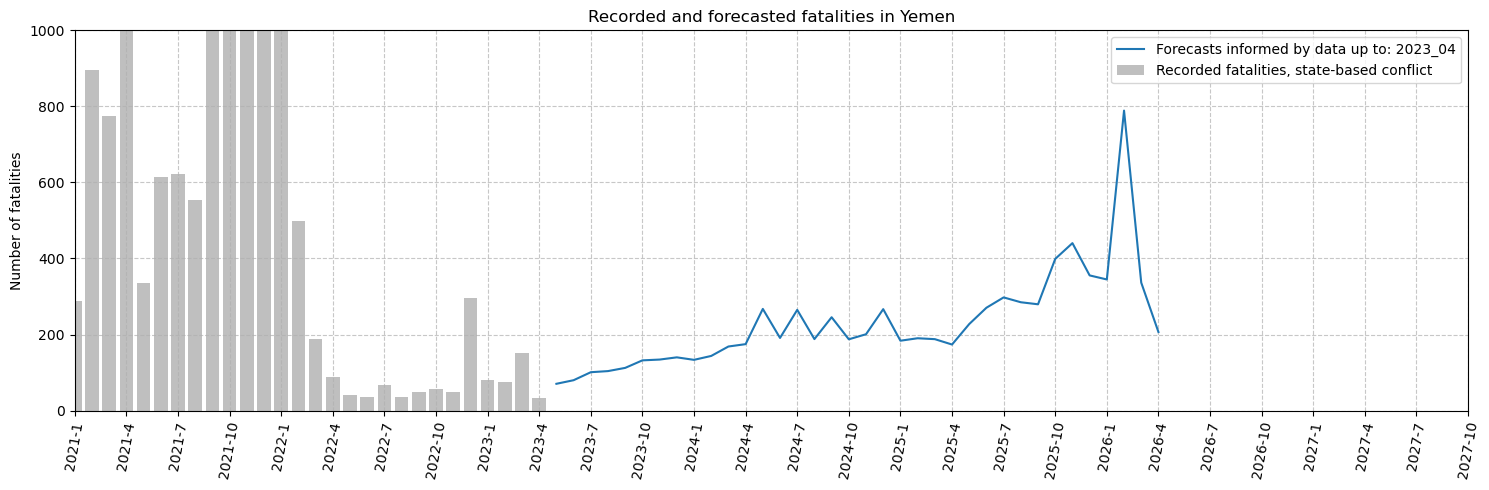

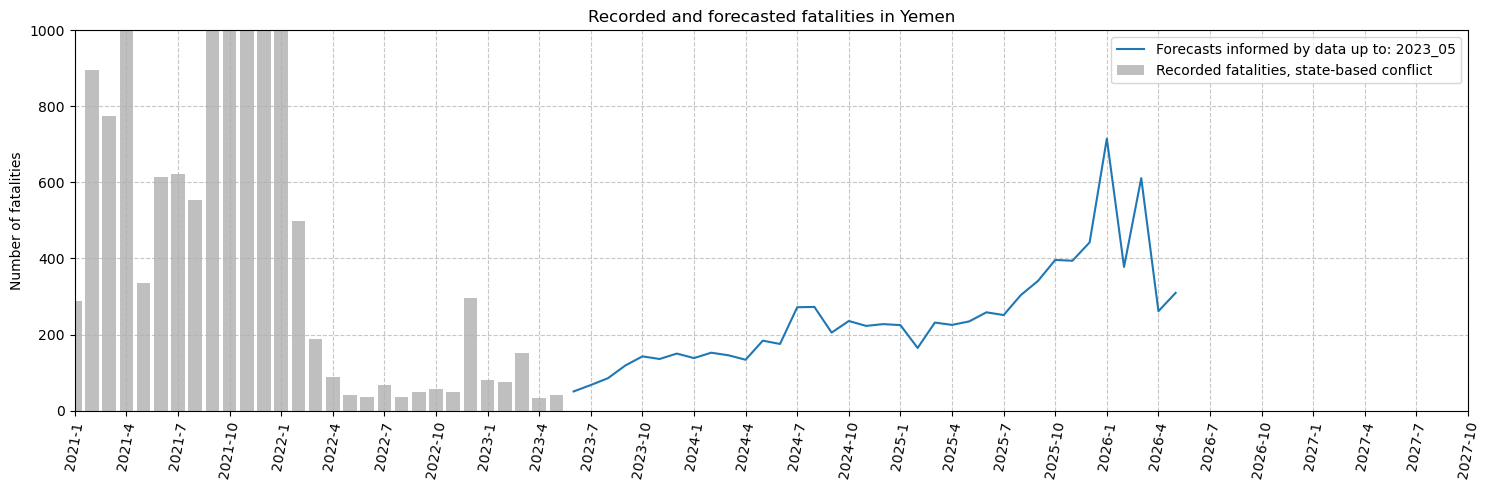

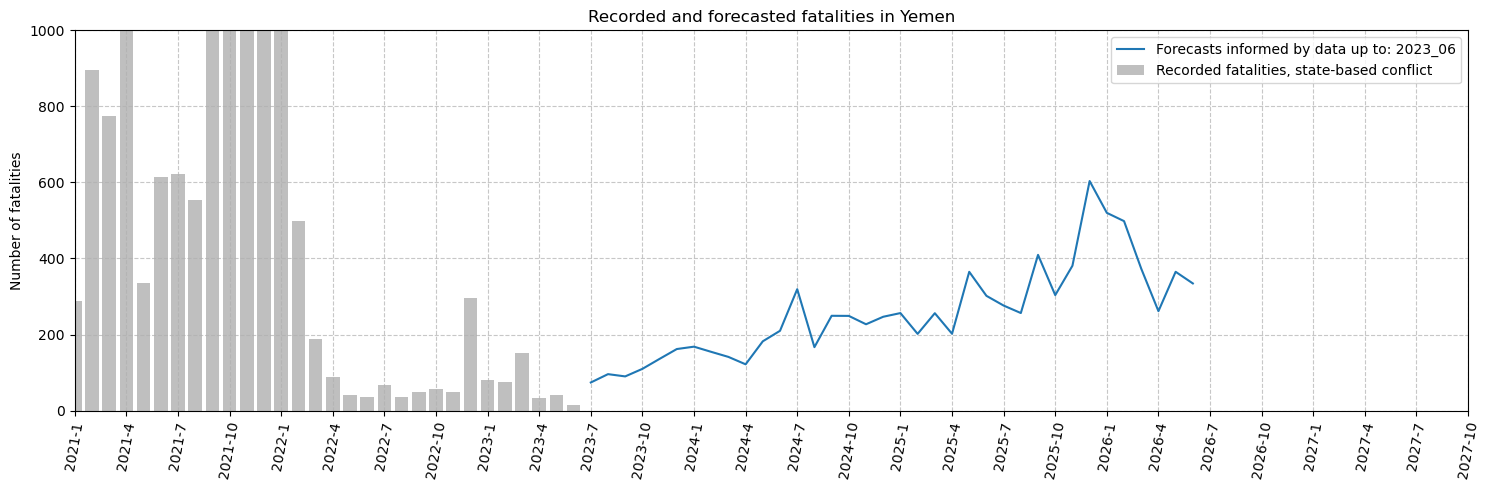

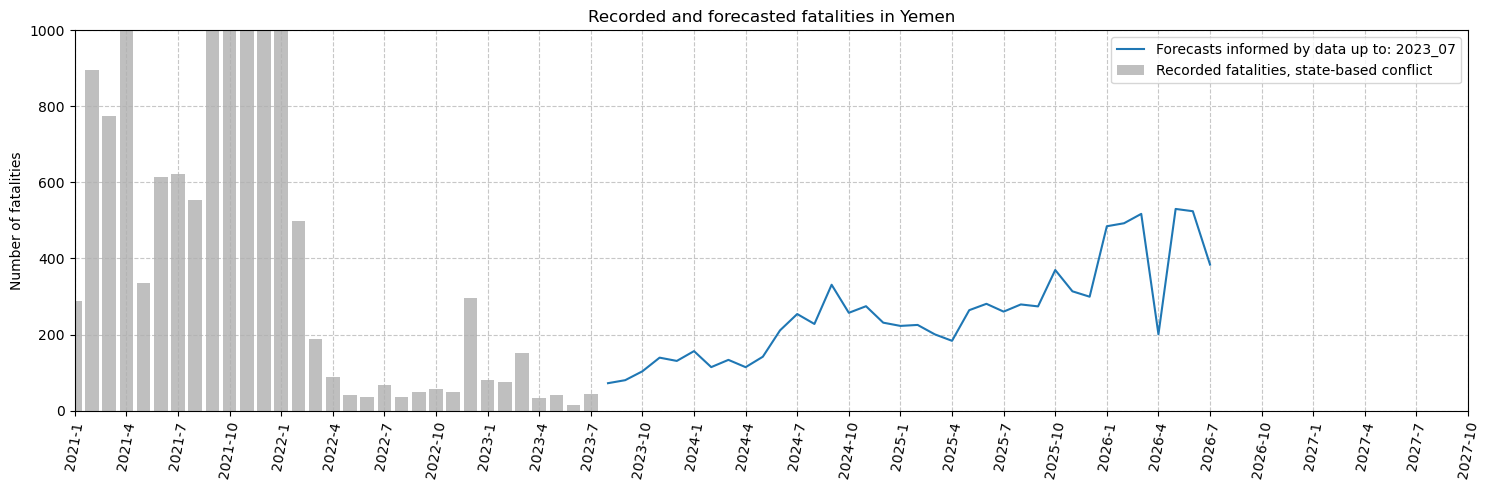

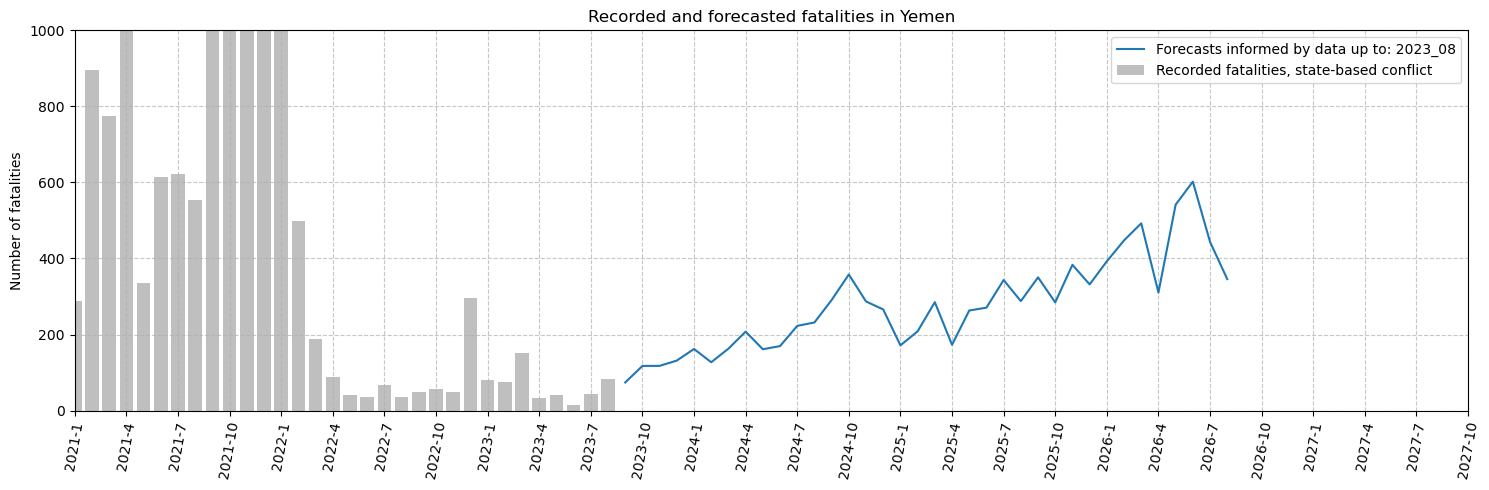

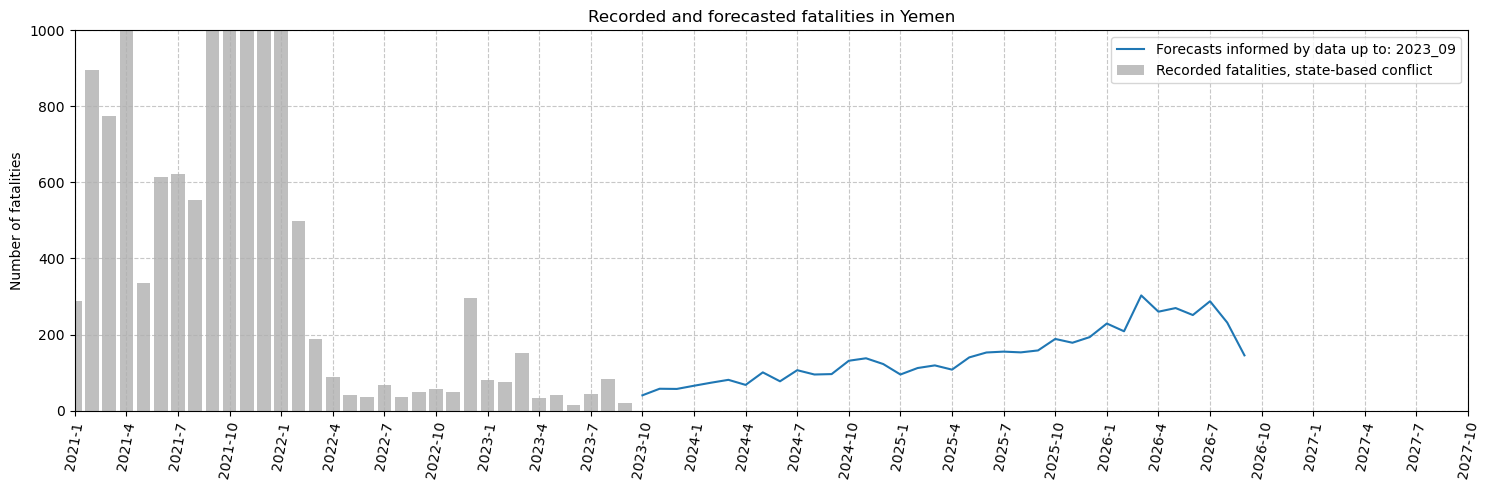

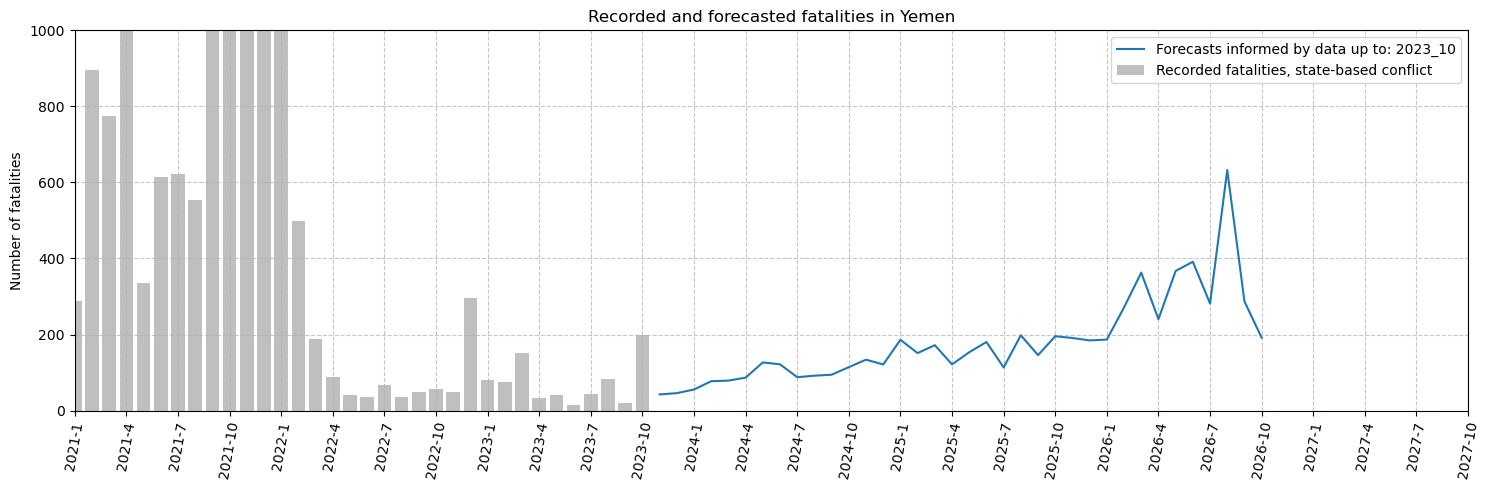

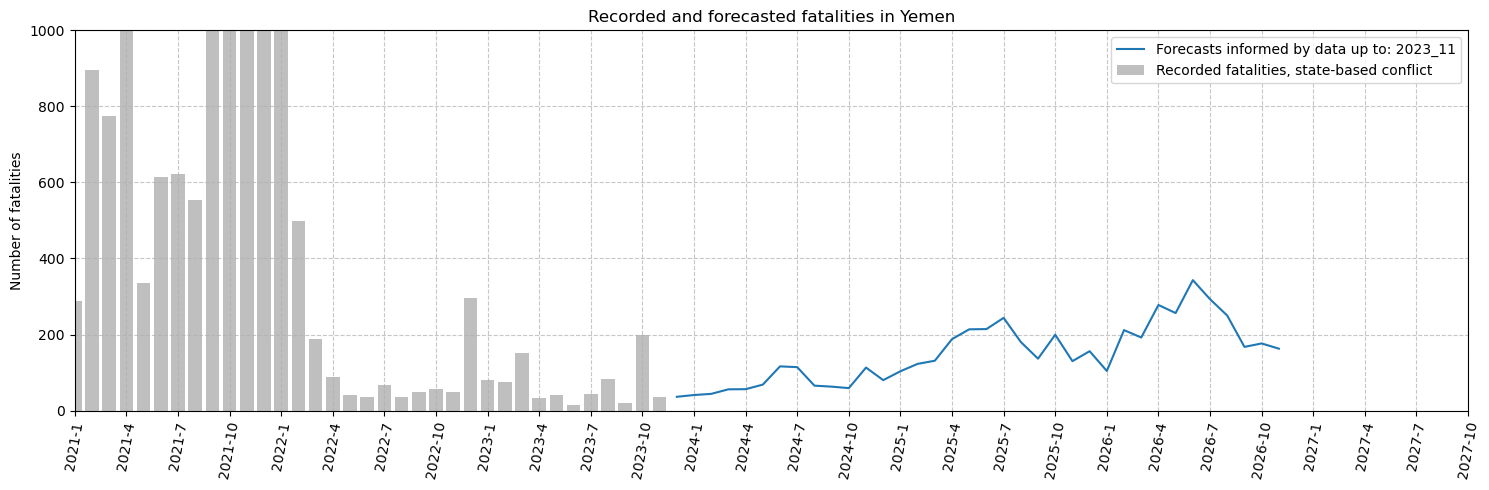

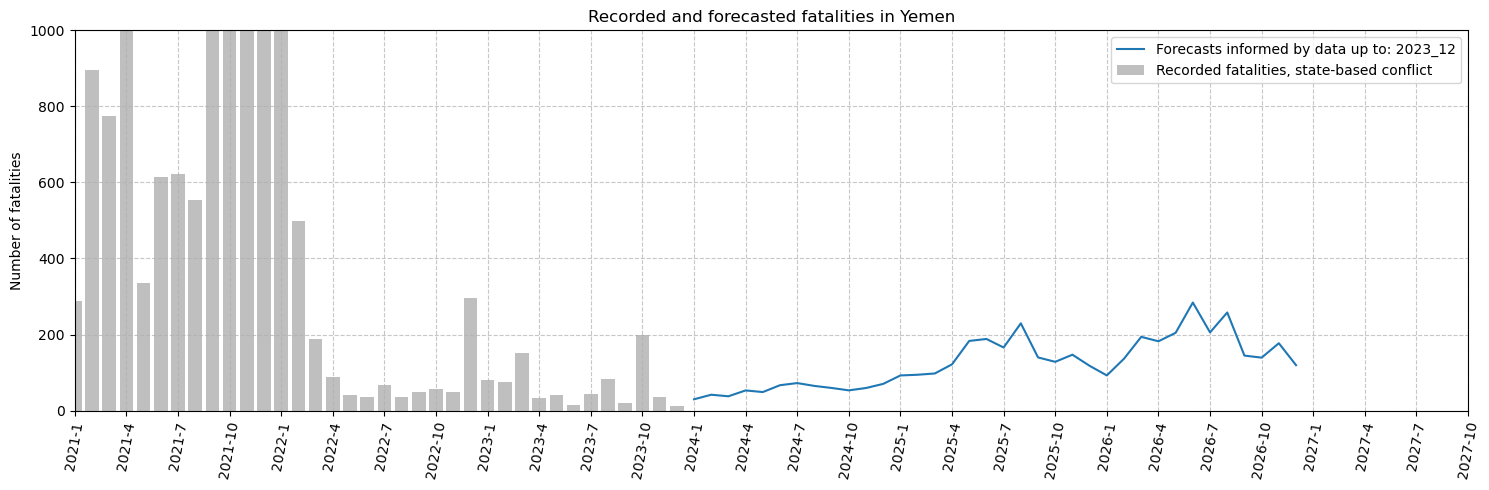

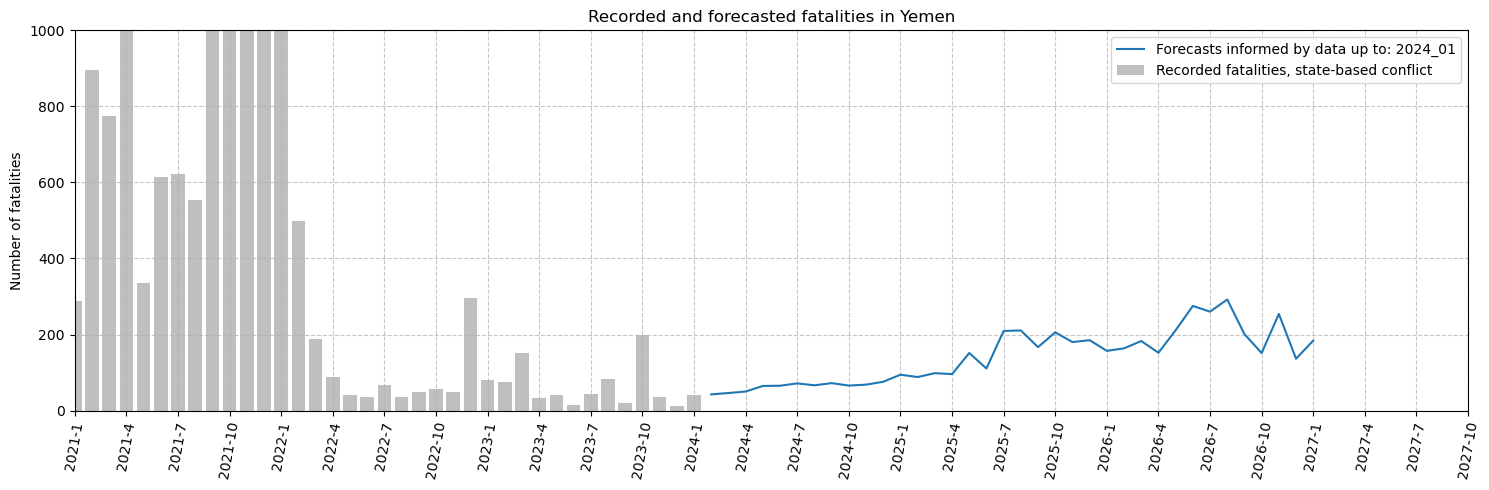

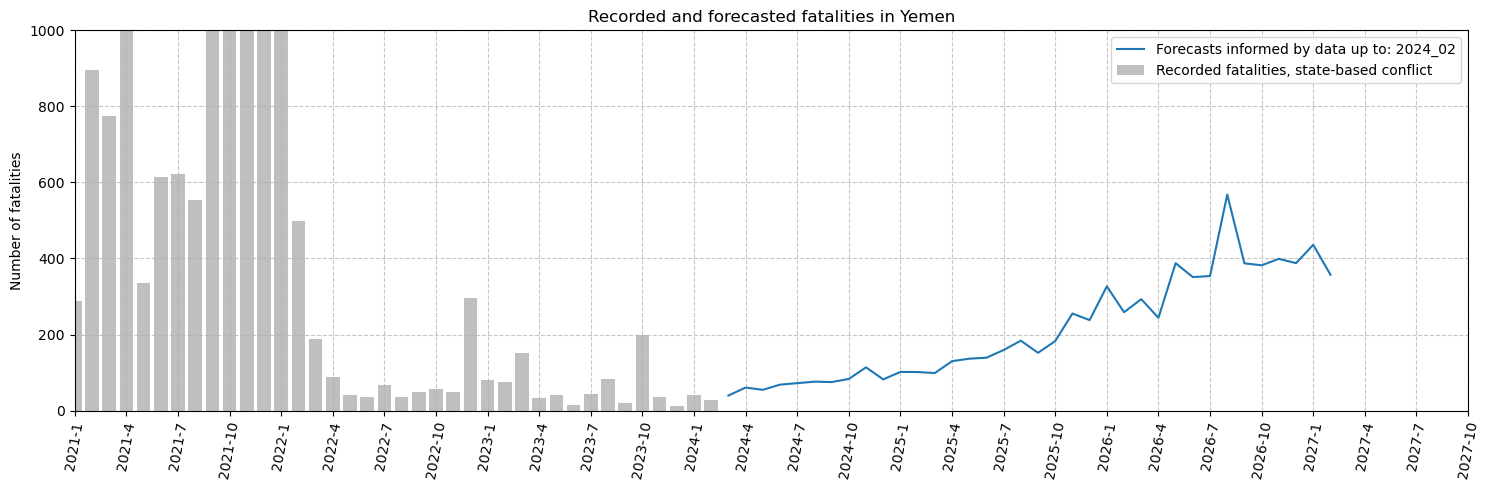

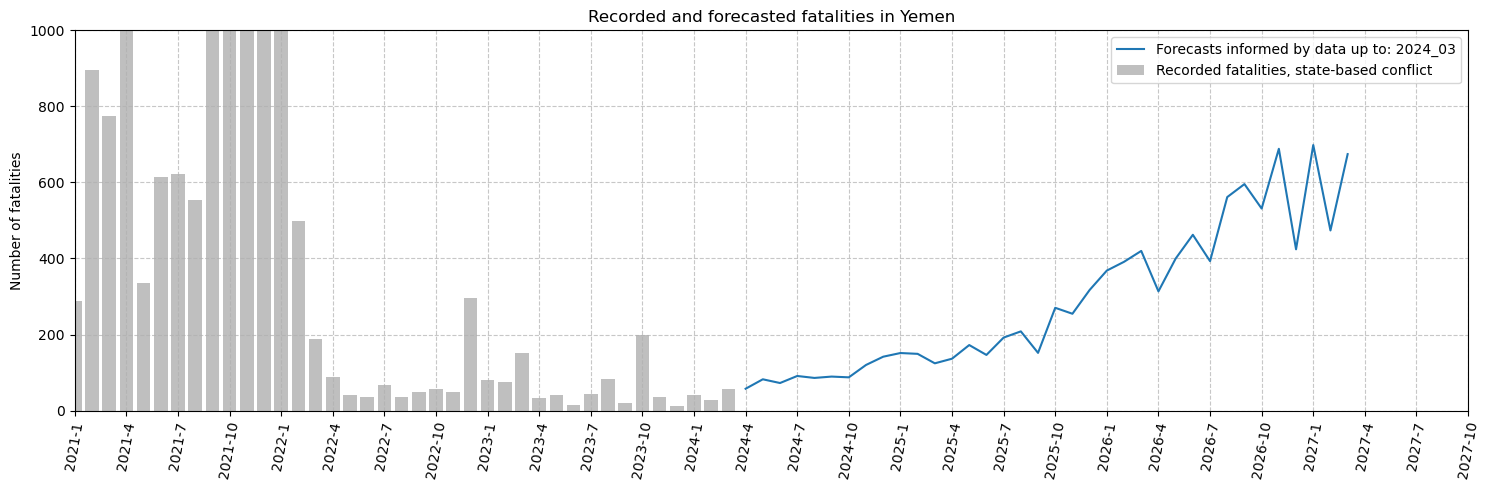

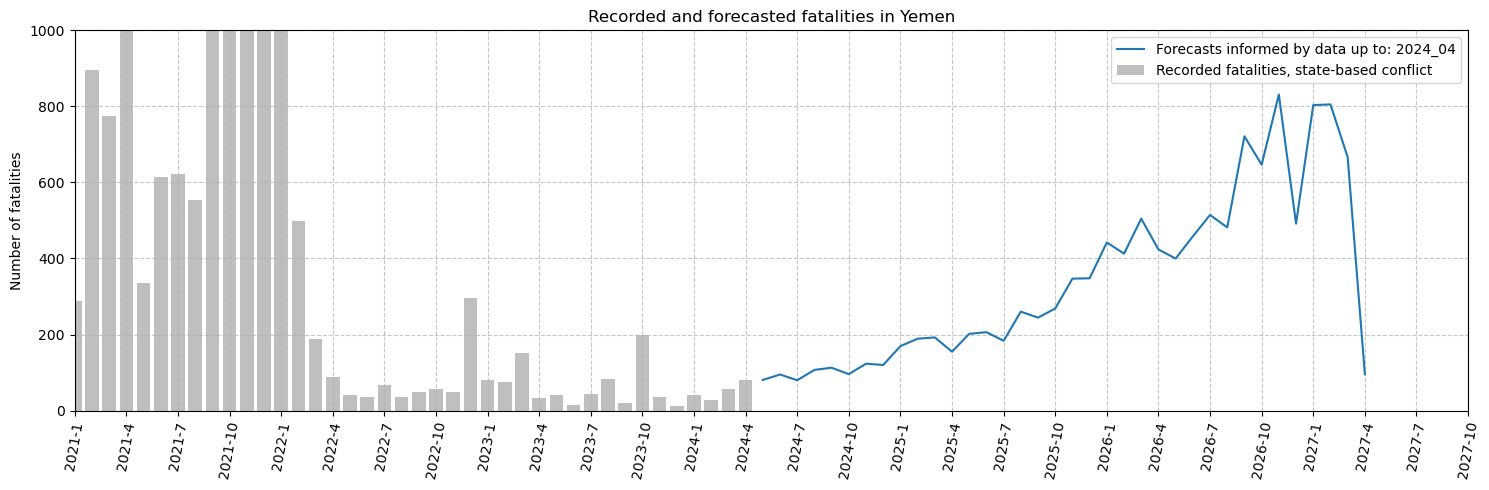

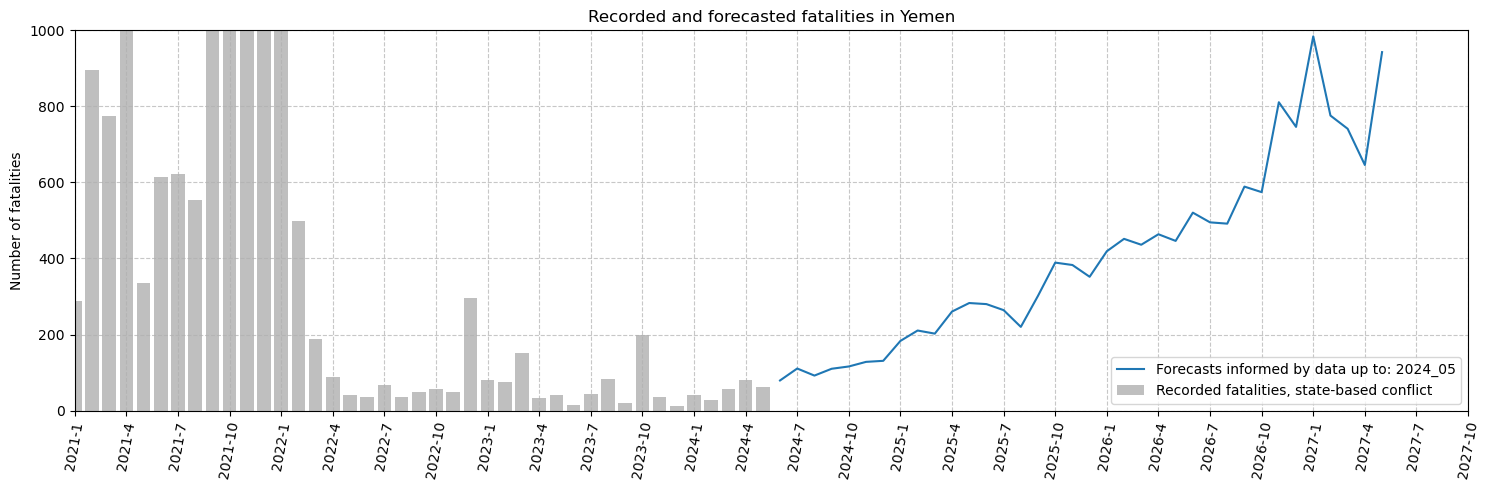

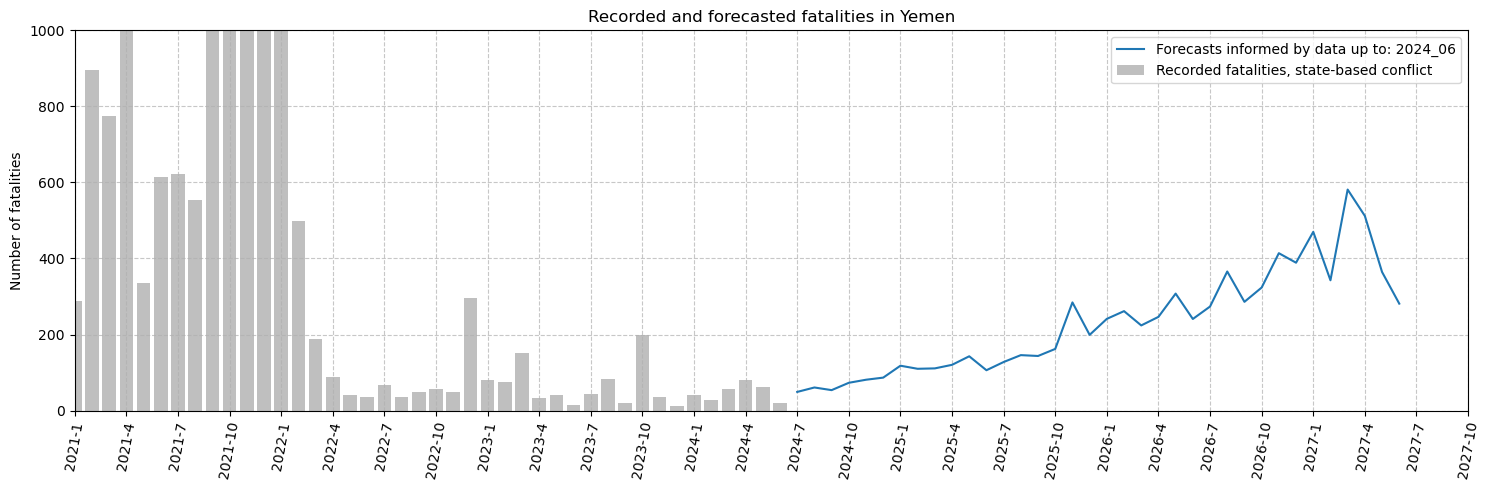

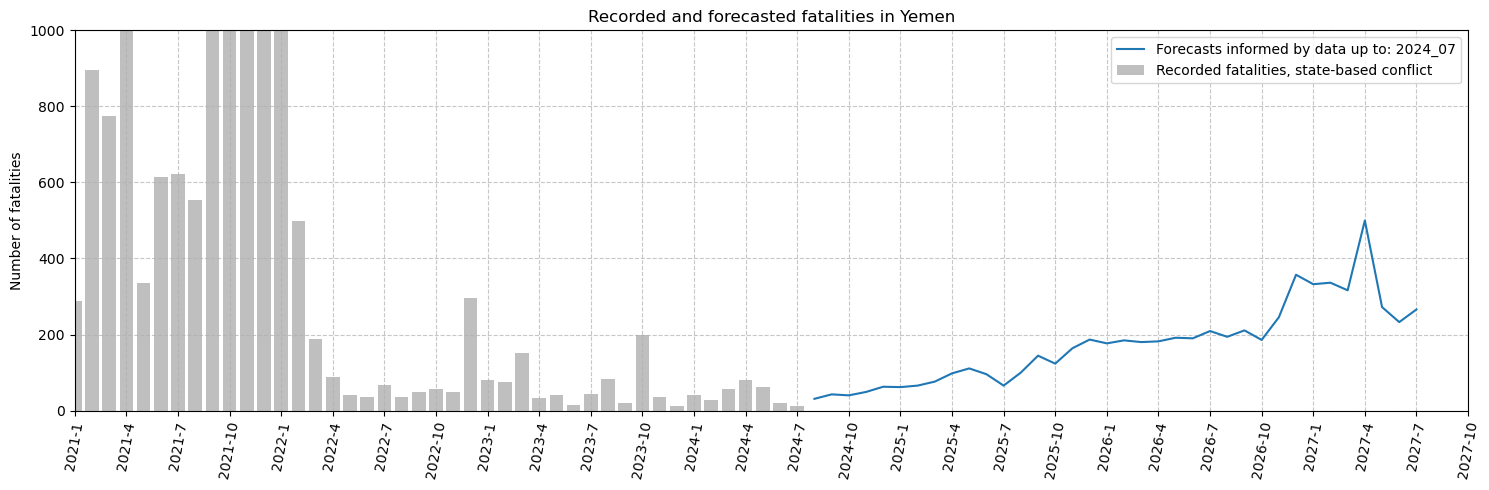

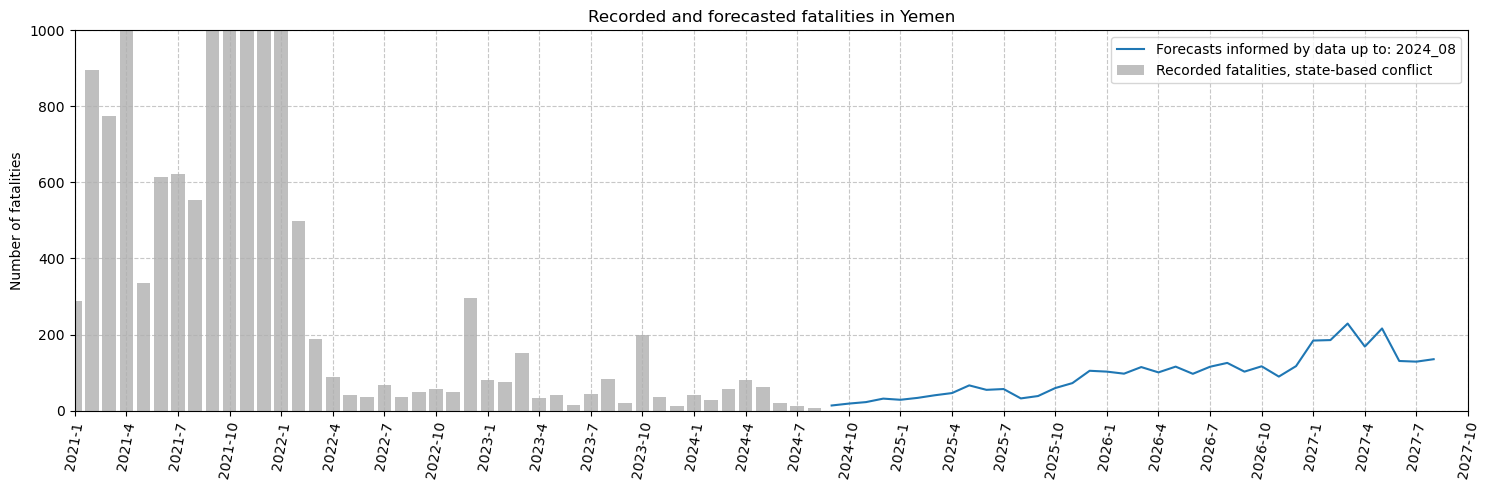

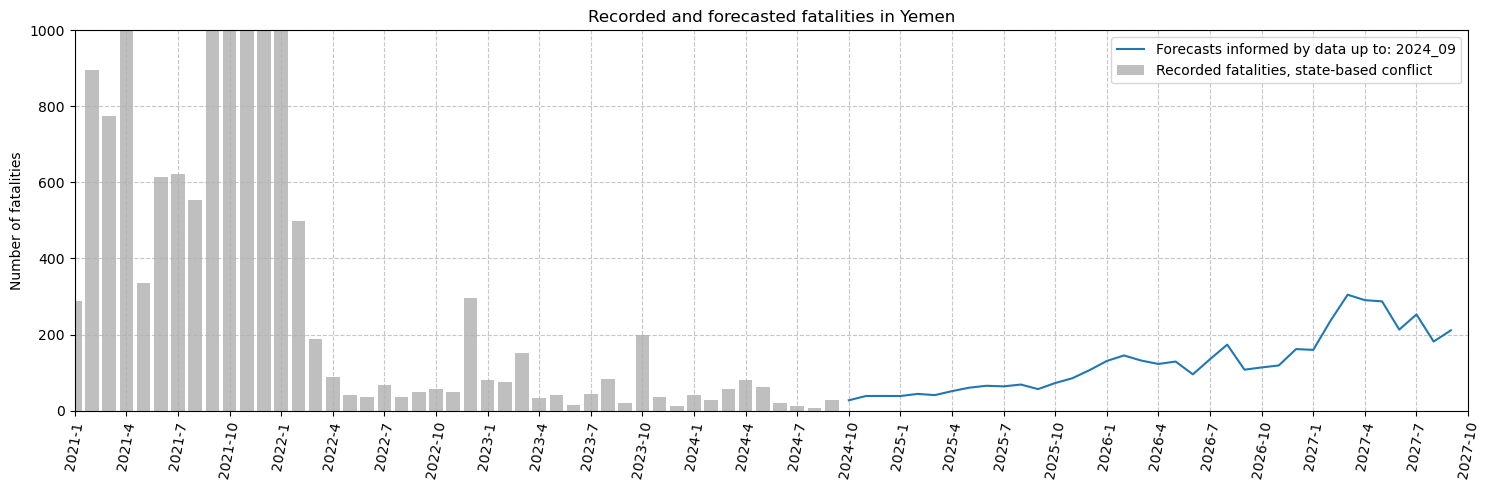

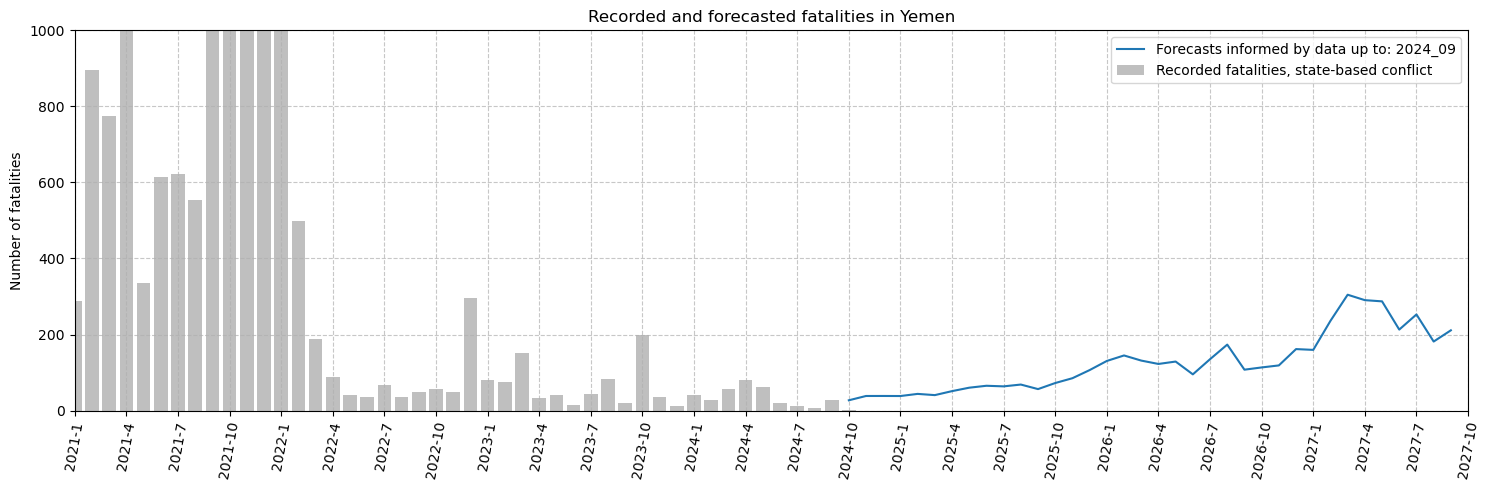

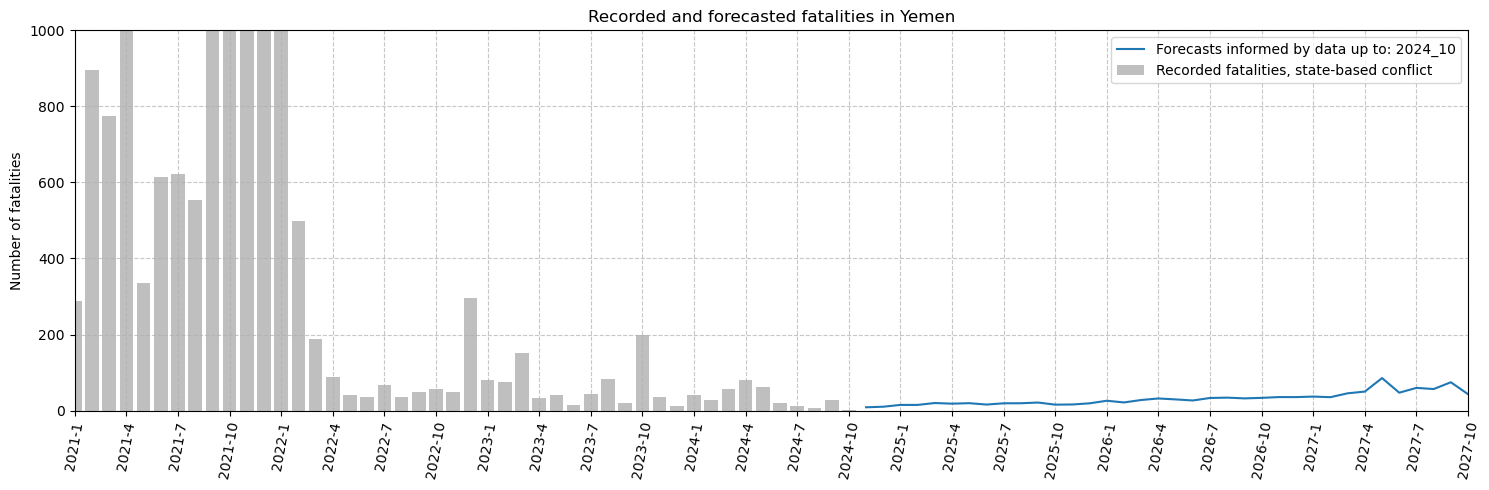

In [10]:
end_date_ucdp = df_2023_04['month_id'].min() - 1  # starting point for UCDP data

# Define min and max dates for the x-axis

min_date = 493  # Replace with desired start date
max_date = 538+36  # Replace with desired end date

for dataset in datasets:

   # Create a new figure for each dataset
    plt.figure(figsize=(15, 5))

    #----- FORECASTS

    # Get the dataset name dynamically
    df_forecasts = f'df_{dataset}'
    forecasts = globals()[df_forecasts]  # Access the DataFrame dynamically

    # Create the line graphs for each forecast DataFrame
    plt.plot(forecasts['month_id'], forecasts['main_mean'], label=f'Forecasts informed by data up to: {dataset}')

    #----- UCDP

    # Filter the UCDP dataset by 'month_id'
    UCDP_filtered = UCDP[(UCDP['month_id'] >= min_date) & (UCDP['month_id'] <= end_date_ucdp)]

    # Plot the UCDP data as bars
    plt.bar(
        UCDP_filtered['month_id'], 
        UCDP_filtered['ucdp_ged_sb_best_sum'], 
        alpha=0.5,  # Transparency
        color='grey',  # Bar color
        label='Recorded fatalities, state-based conflict'
    )
    
    end_date_ucdp += 1  # Increment the end date for the next dataset

    #----- Settings

    # Map month_id to corresponding Date values for x-ticks
    x_ticks = list(UCDP['month_id'].unique())  # Use unique month_id values for the x-ticks
    x_labels = [month_id_to_date_dict.get(month_id, str(month_id)) for month_id in x_ticks]  # Get corresponding date labels

    # Filter x_ticks and x_labels to include only every 3rd tick
    x_ticks = x_ticks[::3]  # Select every 3rd tick
    x_labels = x_labels[::3]  # Ensure labels match the selected ticks

    plt.title(f'Recorded and forecasted fatalities in Yemen')

    # Set x-ticks with the corresponding Date string labels
    plt.xticks(x_ticks, x_labels, rotation=80)  # Set custom ticks and labels on the x-axis
    # Set x-axis limits
    plt.xlim([min_date, max_date])

    # Set y-axis limits
    plt.ylim([0, 1000])
    plt.ylabel("Number of fatalities")

    # Show grid lines across the whole plot
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the legend
    plt.legend()

    # Adjust the layout
    plt.tight_layout()

    # Display the plot
    #plt.show()

    # Save the plot
    plt.savefig(f'/Users/alm/Desktop/Yemen_actuals-forecasts_{dataset}.png')

# Plot all

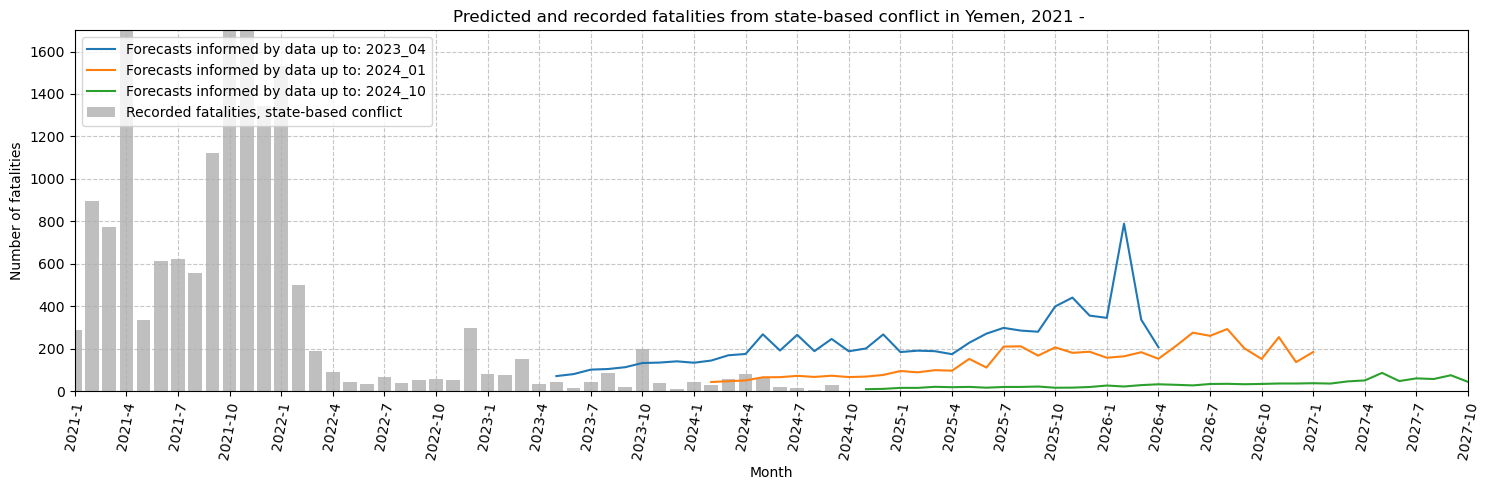

In [22]:
datasets_subset = ['2023_04','2024_01','2024_10']

# Set figure width
plt.rcParams["figure.figsize"] = (15, 5)

# Define min and max dates for the x-axis

min_date = 493  # Replace with desired start date
max_date = 574  # Replace with desired end date

# FORECASTS

for dataset in datasets_subset:
    # Get the dataset name dynamically
    df_forecasts = f'df_{dataset}'
    forecasts = globals()[df_forecasts]  # Access the DataFrame dynamically

    # Create the line graphs for each forecast DataFrame
    plt.plot(forecasts['month_id'], forecasts['main_mean'], label=f'Forecasts informed by data up to: {dataset}')

    # UCDP

# Filter the UCDP dataset by 'month_id'
UCDP_filtered = UCDP[(UCDP['month_id'] >= min_date) & (UCDP['month_id'] <= max_date)]

# Plot the UCDP data as bars
plt.bar(
    UCDP_filtered['month_id'], 
    UCDP_filtered['ucdp_ged_sb_best_sum'], 
    alpha=0.5,  # Transparency
    color='grey',  # Bar color
    label='Recorded fatalities, state-based conflict'
)

# Map month_id to corresponding Date values for x-ticks
x_ticks = list(UCDP['month_id'].unique())  # Use unique month_id values for the x-ticks
x_labels = [month_id_to_date_dict.get(month_id, str(month_id)) for month_id in x_ticks]  # Get corresponding date labels

# Filter x_ticks and x_labels to include only every 3rd tick
x_ticks = x_ticks[::3]  # Select every 3rd tick
x_labels = x_labels[::3]  # Ensure labels match the selected ticks

# Set x-ticks with the corresponding Date string labels
plt.xticks(x_ticks, x_labels, rotation=80)  # Set custom ticks and labels on the x-axis


# Set x-axis limits
plt.xlim([min_date, max_date])

# Customize the graph
plt.title("Predicted and recorded fatalities from state-based conflict in Yemen, 2021 - ")
plt.xlabel("Month")
plt.ylabel("Number of fatalities")

# Show grid lines across the whole plot
plt.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits
plt.ylim([0, 1700])

# Show the legend
plt.legend()

# Adjust the layout
plt.tight_layout()

# Save the plot
plt.savefig(f'/Users/alm/Desktop/Yemen_combined_line_bar_plot.png')

# Display the plot
plt.show()


# Plot GED

In [13]:
PAGE_SIZE = 1000

# Construct the API URL
VIEWS_URL = f'https://api.viewsforecasting.org/predictors_fatalities002_0000_00/cm/px?iso=YEM&page_size={PAGE_SIZE}'
master_list = []

# Initial API request
r = requests.get(VIEWS_URL)
page_data = r.json()

# Append the data from the first page
master_list += page_data['data']

# Handle pagination
while page_data.get('next_page'):
    r = requests.get(page_data['next_page'])
    page_data = r.json()
    master_list += page_data['data']

# Convert the collected data to a DataFrame
ged_raw = pd.DataFrame(master_list)

# Create a 'Date' column by combining 'year' and 'month'
ged_raw['Date'] = ged_raw['year'].astype(str) + '-' + ged_raw['month'].astype(str)

UCDP = ged_raw.sort_values('month_id')  # Ensure ascending order



In [14]:
# Rename columns for the plot

UCDP.rename(columns = {'ucdp_ged_sb_best_sum':'State-based', 'ucdp_ged_ns_best_sum':'Non-state', 'ucdp_ged_os_best_sum':'One-sided'}, inplace = True)
UCDP

,country_id,month_id,name,gwcode,isoab,year,month,wb_wdi_sp_dyn_le00_in,vdem_v2xcl_acjst,wb_wdi_sp_dyn_imrt_in,...,vdem_v2x_libdem,One-sided,vdem_v2x_rule,wb_wdi_se_prm_nenr,Non-state,vdem_v2xeg_eqdr,wb_wdi_ny_gdp_pcap_kd,vdem_v2x_gender,wb_wdi_sp_pop_totl,Date
0,196,121,Yemen Arab Republic,678,YEM,1990,1,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1990-1
1,196,122,Yemen Arab Republic,678,YEM,1990,2,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1990-2
2,196,123,Yemen Arab Republic,678,YEM,1990,3,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1990-3
3,196,124,Yemen Arab Republic,678,YEM,1990,4,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1990-4
4,196,125,Yemen Arab Republic,678,YEM,1990,5,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1990-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,124,534,Yemen,678,YEM,2024,6,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2024-6
416,124,535,Yemen,678,YEM,2024,7,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2024-7
417,124,536,Yemen,678,YEM,2024,8,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,31.0,NaN,NaN,NaN,NaN,2024-8
418,124,537,Yemen,678,YEM,2024,9,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2024-9


In [15]:
# Filter the data to include only the desired time period

StartOfHistory = 409
EndOfHistory = 538

UCDP_filtered = UCDP[(UCDP['month_id'] >= StartOfHistory) & (UCDP['month_id'] <= EndOfHistory)]
UCDP_filtered


,country_id,month_id,name,gwcode,isoab,year,month,wb_wdi_sp_dyn_le00_in,vdem_v2xcl_acjst,wb_wdi_sp_dyn_imrt_in,...,vdem_v2x_libdem,One-sided,vdem_v2x_rule,wb_wdi_se_prm_nenr,Non-state,vdem_v2xeg_eqdr,wb_wdi_ny_gdp_pcap_kd,vdem_v2x_gender,wb_wdi_sp_pop_totl,Date
290,124,409,Yemen,678,YEM,2014,1,67.384,0.164,45.4,...,0.125,0.0,0.113,NaN,0.0,0.179,2123.9353,0.215,27753304.0,2014-1
291,124,410,Yemen,678,YEM,2014,2,67.384,0.164,45.4,...,0.125,0.0,0.113,NaN,0.0,0.179,2123.9353,0.215,27753304.0,2014-2
292,124,411,Yemen,678,YEM,2014,3,67.384,0.164,45.4,...,0.125,0.0,0.113,NaN,0.0,0.179,2123.9353,0.215,27753304.0,2014-3
293,124,412,Yemen,678,YEM,2014,4,67.384,0.164,45.4,...,0.125,0.0,0.113,NaN,0.0,0.179,2123.9353,0.215,27753304.0,2014-4
294,124,413,Yemen,678,YEM,2014,5,67.384,0.164,45.4,...,0.125,0.0,0.113,NaN,3.0,0.179,2123.9353,0.215,27753304.0,2014-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,124,534,Yemen,678,YEM,2024,6,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2024-6
416,124,535,Yemen,678,YEM,2024,7,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2024-7
417,124,536,Yemen,678,YEM,2024,8,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,31.0,NaN,NaN,NaN,NaN,2024-8
418,124,537,Yemen,678,YEM,2024,9,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2024-9


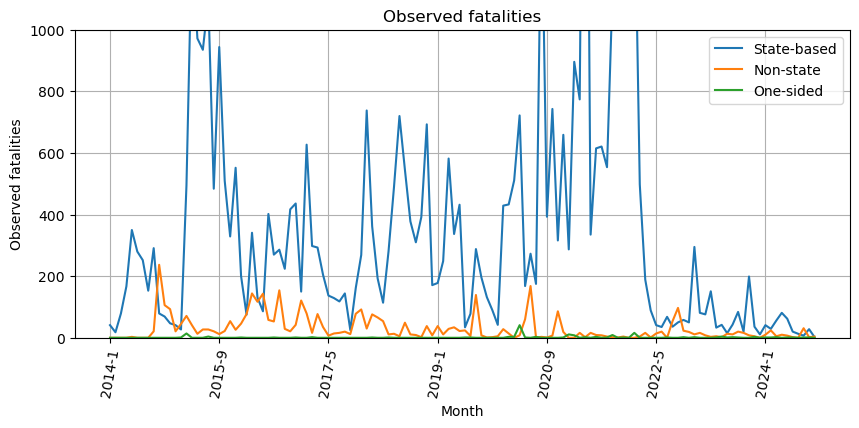

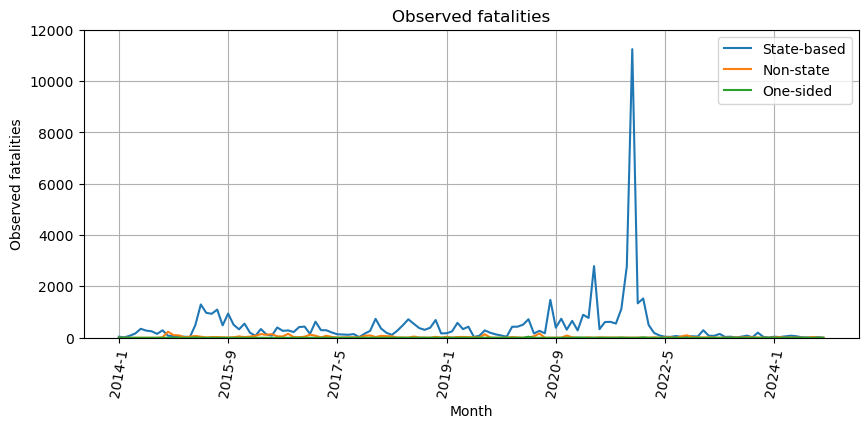

In [16]:

# Create the line graph, for all three types of violence, for two different ranges on the y-axis

ylimits = [[0, 1000], [0, 12000]]

for ylimit in ylimits:

    UCDP_filtered.plot(x="Date", y=["State-based", "Non-state", "One-sided"],figsize=(10, 4))
    # Customize the graph
    plt.title(f'Observed fatalities')
    plt.xlabel("Month")
    plt.xticks(rotation = 80) # Rotates X-Axis Ticks by 45-degrees
    plt.ylabel("Observed fatalities")
    plt.grid()
    # Use the ax settings below to cap the x and y axes
    ax = plt.gca()
    #ax.set_xlim([xmin, xmax])
    ax.set_ylim(ylimit)
    plt.savefig(f'/Users/alm/Desktop/GED_all_{ylimit}.png', bbox_inches='tight')

In [12]:
print('All done!')

All done!
